<a href="https://colab.research.google.com/github/SkyttRPS/DeepSpeechAnalysis/blob/main/SpeechEmotionRecognition_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speech Emotion Recognition
In order to import our data set to colaboratory, we need to run a set of commands to install kaggle, make a directory, copy the API kaggle.json file, give permissions, download the data set and finally unzip it.



In [ ]:
! mkdir ~/.kaggle

In [14]:
! cp kaggle.json ~/.kaggle/

In [15]:
! chmod 600 ~/.kaggle/kaggle.json


In [ ]:
! kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

In [ ]:
! unzip /content/ravdess-emotional-speech-audio.zip

In [ ]:
! pip install tensorflow

# RAVDESS Dataset
The employed dataset is the RAVDESS dataset provided on [Kaggle](https://www.kaggle.com/uwrfkaggler/ravdess-emotional-speech-audio).

*   Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
*   Vocal channel (01 = speech, 02 = song).
*   Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
*   Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
*   Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
*   Repetition (01 = 1st repetition, 02 = 2nd repetition).
*   Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

*Example file: 03-01-08-01-01-02-11.wav*

1.   Audio-only (03)
2.   Speech (01)
3.   Surprised (08)
4.   Normal (01)
5.   Statement "Kids" (01)
6.   2nd Repetition (02)
7.   Actor 11 (11)
     Male, as the ID is odd.

# Importing libraries

In [19]:
# Libraries used for Data Analysis
import pandas as pd
import numpy as np

# Libraries used to navigate, manipulate and use data in the operating file system
import os
import sys

# Librosa lets us use Python for extracting and analysing data from audio files
import librosa
import librosa.display

# Seaborn and matplotlib are libraries used for plotting data into informative graphs
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn is a library used to perform machine learning processes 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# IPython is a Jupyter based library which we use to play audio in the notebook
import IPython.display as ipd

# TensorFlow is the platform that opens possibilites for end-to-end machine learning, Keras is the framework used 
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical

import warnings
if not sys.warnoptions:
  warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

#Preparing the dataset

In [94]:
# Making sure we can access the dataset directory 
# RAVDESS set path
RAVDESS = "/content/audio_speech_actors_01-24/"
dlist = os.listdir(RAVDESS)
dlist.sort()

# Creating two empty lists to store emotion and file path
emotion = []
path = []

# Looping through the directory
for i in dlist:
    fname = os.listdir(RAVDESS + i)
    for f in fname:
        # Splitting the string to read the identifiers from the file name
        part = f.split('.')[0]
        part = part.split('-')
        # The documentations tells the third part of the file represents the emotion
        emotion.append(int(part[2])) 
        path.append(RAVDESS + i + '/' + f)

# Creating dataframes for emotions and file paths
emotion_df = pd.DataFrame(emotion, columns=['Emotions'])
path_df = pd.DataFrame(path, columns=['Path'])

# Merging the Emotions and Path dataframes into a 
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# Changing integers to emotions.
Ravdess_df.Emotions.replace(
    {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head(8) # outputs the first 8 index'

,Emotions,Path
0,happy,/content/audio_speech_actors_01-24/Actor_01/03...
1,calm,/content/audio_speech_actors_01-24/Actor_01/03...
2,happy,/content/audio_speech_actors_01-24/Actor_01/03...
3,neutral,/content/audio_speech_actors_01-24/Actor_01/03...
4,fear,/content/audio_speech_actors_01-24/Actor_01/03...
5,surprise,/content/audio_speech_actors_01-24/Actor_01/03...
6,happy,/content/audio_speech_actors_01-24/Actor_01/03...
7,fear,/content/audio_speech_actors_01-24/Actor_01/03...


Converting the dataset to a set of comma seperated values

In [22]:
data_path = Ravdess_df
Ravdess_df.to_csv("data_path.csv",index=False)
data_path.head(8)

,Emotions,Path
0,happy,/content/audio_speech_actors_01-24/Actor_01/03...
1,calm,/content/audio_speech_actors_01-24/Actor_01/03...
2,happy,/content/audio_speech_actors_01-24/Actor_01/03...
3,neutral,/content/audio_speech_actors_01-24/Actor_01/03...
4,fear,/content/audio_speech_actors_01-24/Actor_01/03...
5,surprise,/content/audio_speech_actors_01-24/Actor_01/03...
6,happy,/content/audio_speech_actors_01-24/Actor_01/03...
7,fear,/content/audio_speech_actors_01-24/Actor_01/03...


#Visualising the data

In order to implement and apply our deep neural network, we need to visualise it in a format that can be recognized by the architecture. 

Prior to the visualisation, we make sure the audio is playable in the notebook, to crosscheck with the dataframe
*   **Waveplots** are used to visualise the audio levels or loudness through time in the file
*   **Spectrograms** are used to visualise a spectrum of frequencies of time from an audio signal



In [23]:
# Defining function for creating a waveplot
def create_wplot(data, sr, emotion):
    plt.figure(figsize=(15, 5))
    plt.title('Waveplot for audio with {} emotion'.format(emotion), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

# Defining function for creating and visualing a spectrogram
def create_spectrogram(data, sr, emotion):
    # sftf is a Librosa function used to apply fourier transformation
    # Fourier transformation is a mathematical function used to break a signal into a time/frequency space
    x = librosa.stft(data)
    db = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(15, 5))
    plt.title('Spectrogram for audio with {} emotion'.format(emotion), size=15)
    
    # Librosa function for displaying a generated spectrogram
    librosa.display.specshow(db, sr=sr, x_axis='time', y_axis='hz')   
    # adding a colourbar to indicate signal decibel levels
    plt.colorbar(format='%+2.0f dB')

# Visualising emotion
These representations prepare the data for further augmentation before practicing feature extractation and running the training model.

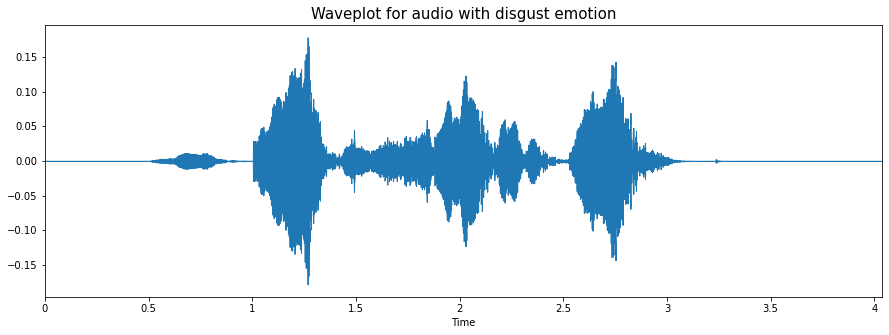

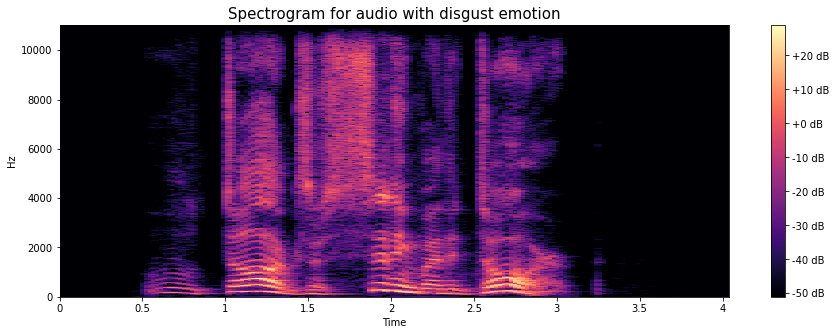

In [111]:
# An example of the unprocessed visual audio models, using the disgust emotion.
emotion='disgust'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_wplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
ipd.Audio(path)

# Data Augmentation

In [32]:
#Creating a function which adds some minor background noise (clutter)
def noise(data):
    noise_amp = 0.02*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

#Creating a function which allow us to strech the wavelenght abit.
def stretch(data, rate = 0.85):
    return librosa.effects.time_stretch(data,rate)

#Function for time shifting
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high =5)*1000)
    return np.roll(data, shift_range)

#Function for pitch changing
def pitch(data, sampling_rate, pitch_factor = 0.5):
    return librosa.effects.pitch_shift(data,sampling_rate,pitch_factor)

def pitch2(data, sampling_rate, pitch_factor = 0.35):
    return librosa.effects.pitch_shift(data,sampling_rate,pitch_factor)

def pitch3(data, sampling_rate, pitch_factor = 0.7):
    return librosa.effects.pitch_shift(data,sampling_rate,pitch_factor)

def noise2(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def noise3(data):
    noise_amp = 0.05*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data



# Feature Extraction

Before creating a funtion to extract all desired features at once, we create test on file to extract spectrograms for each feature and give visual proof 

[Text(0.5, 1.0, 'Mel Spectrogram for Disgust emotion with noise')]

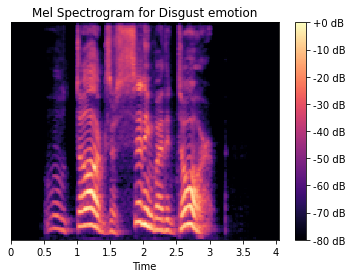

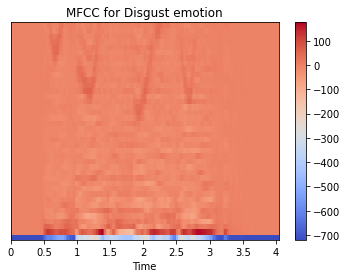

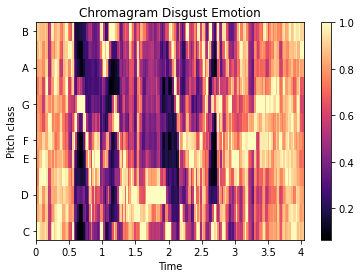

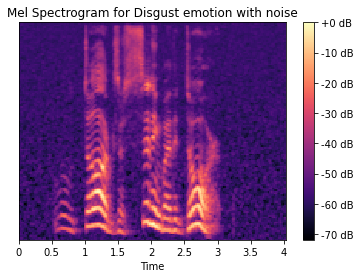

In [110]:
# Feature extraction and augmentation visualisation
emotion='disgust'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
aug_noise = noise(data)

# Visualing Mel Spectrogram
mel = librosa.feature.melspectrogram(y=data, sr=sampling_rate)
mel_dB = librosa.power_to_db(mel, ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(mel_dB, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel Spectrogram for Disgust emotion')

# Visualising MFCC
mfcc = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=40)
fig, ax = plt.subplots()
img = librosa.display.specshow(mfcc, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC for Disgust emotion')

# Visualing Chroma STFT
stft = np.abs(librosa.stft(data))
chroma_stft = librosa.feature.chroma_stft(S=stft, sr=sampling_rate)
fig, ax = plt.subplots()
img = librosa.display.specshow(chroma_stft, y_axis='chroma', x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='Chromagram Disgust Emotion')

# Visualising noise augmentation data in mel spectrogram
mel = librosa.feature.melspectrogram(y=aug_noise, sr=sampling_rate)
mel_dB = librosa.power_to_db(mel, ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(mel_dB, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel Spectrogram for Disgust emotion with noise')

In [58]:
# Defining feature extraction functions
# returning the mean of the librosa functions and stacking the data horizontally

def extract_features(data):
  result = np.array([])
  # Zero Crossing Rate (ZCR)
  zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
  result=np.hstack((result, zcr))

  # Chroma Short Fourier Transform (STFT)
  stft = np.abs(librosa.stft(data))
  chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sampling_rate).T, axis=0)
  result = np.hstack((result, chroma_stft)) 

  # Mel-frequency cepstrum coefficient (MFCC)
  mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sampling_rate).T, axis=0)
  result = np.hstack((result, mfcc))

  # Mel Spectogram
  melspec = np.mean(librosa.feature.melspectrogram(y=data, sr=sampling_rate).T, axis=0)
  result = np.hstack((result, melspec))

  return result

In [59]:
# Get features function
def get_features(path):
    data, sample_rate = librosa.load(path,duration=2.5,offset=0.6)

    # Unaugmented data
    res1 = extract_features(data)
    result = np.array(res1)

    # Data augmented with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result,res2))

    #Data augmented with stretch and pitch
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data,sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result,res3))

    #Data augmented with timeshift
    timeshifted = shift(data)
    res4 = extract_features(timeshifted)
    result = np.vstack((result,res4))

    #Data Augmented with stretch and noise
    new_data2 = stretch(data)
    stretched_noise = noise(new_data2)
    res5 = extract_features(stretched_noise)
    result = np.vstack((result,res5))

    #Data augmented with noise and pitch
    pitchedNoise = noise(data)
    Pnoise2 = pitch(pitchedNoise,sample_rate)
    res6 = extract_features(Pnoise2)
    result = np.vstack((result, res6))

    # Data augmented with noise
    noise_data = noise2(data)
    res7 = extract_features(noise_data)
    result = np.vstack((result,res7))

    #Data augmented with stretch and pitch
    new_data = stretch(data)
    data_stretch_pitch = pitch2(new_data,sample_rate)
    res8 = extract_features(data_stretch_pitch)
    result = np.vstack((result,res8))

    # Data augmented with noise
    noise_data = noise3(data)
    res9 = extract_features(noise_data)
    result = np.vstack((result,res9))

    #Data augmented with stretch and pitch
    new_data = stretch(data)
    data_stretch_pitch = pitch3(new_data,sample_rate)
    res10 = extract_features(data_stretch_pitch)
    result = np.vstack((result,res10))
    
    #Data augmented with pitch
    NDpi1 = pitch(new_data,sample_rate)
    res11 = extract_features(NDpi1)
    result = np.vstack((result,res11))
    
    #Data augmented with pitch
    NDpi2 = pitch2(new_data,sample_rate)
    res12 = extract_features(NDpi2)
    result = np.vstack((result,res12))
    
    #Data augmented with pitch
    NDpi3 = pitch3(new_data,sample_rate)
    res13 = extract_features(NDpi3)
    result = np.vstack((result,res13))
    
    return result

#Making a loop to extract emotions for the extracted features
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv',index = False)
Features.head()




```
# This is formatted as code
```

# Data preparation

In [ ]:
#data preparation 
#we are now split the data for traning and testing 
#the funtion Features.iloc make it possiable to select a specific cell of the dataset

X= Features.iloc[: ,:-1].values
Y = Features['labels'].values

#multiclass classification for Y
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

#splitting the data into test and traning set
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

# scaling data with sklearn
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

#enable data's compareablity to data
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((14040, 161, 1), (14040, 8), (4680, 161, 1), (4680, 8))

# The model

In [ ]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5,strides=1,padding='same',activation='relu',input_shape=(x_train.shape[1],1)))
model.add(MaxPooling1D(pool_size=5,strides=2,padding='same'))

model.add(Conv1D(256, kernel_size=5,strides=1,padding='same',activation='relu'))
model.add(MaxPooling1D(pool_size=5,strides=2,padding='same'))

model.add(Conv1D(128, kernel_size=5,strides=1,padding='same',activation='relu'))
model.add(MaxPooling1D(pool_size=5,strides=2,padding='same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5,strides=1,padding='same',activation='relu'))
model.add(MaxPooling1D(pool_size=5,strides=2,padding='same'))

model.add(Flatten())
model.add(Dense(units=32, activation = 'relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation ='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 161, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 81, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 41, 256)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 21, 128)          0

# Running the model

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor = 0.4, verbose=0, patience = 2, min_lr=0.0000001)
history=model.fit(x_train,y_train,batch_size=64,epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp]) #save model check

Epoch 1/50
220/220 [==============================] - 19s 24ms/step - loss: 1.8831 - accuracy: 0.2573 - val_loss: 1.7306 - val_accuracy: 0.3299 - lr: 0.0010
Epoch 2/50
220/220 [==============================] - 5s 21ms/step - loss: 1.6970 - accuracy: 0.3467 - val_loss: 1.5245 - val_accuracy: 0.4141 - lr: 0.0010
Epoch 3/50
220/220 [==============================] - 4s 20ms/step - loss: 1.5487 - accuracy: 0.4033 - val_loss: 1.4374 - val_accuracy: 0.4797 - lr: 0.0010
Epoch 4/50
220/220 [==============================] - 4s 20ms/step - loss: 1.4366 - accuracy: 0.4511 - val_loss: 1.2498 - val_accuracy: 0.5346 - lr: 0.0010
Epoch 5/50
220/220 [==============================] - 4s 20ms/step - loss: 1.3186 - accuracy: 0.4994 - val_loss: 1.1529 - val_accuracy: 0.5705 - lr: 0.0010
Epoch 6/50
220/220 [==============================] - 5s 21ms/step - loss: 1.2269 - accuracy: 0.5351 - val_loss: 1.0127 - val_accuracy: 0.6226 - lr: 0.0010
Epoch 7/50
220/220 [==============================] - 5s 21ms/s

# Results

147/147 [==============================] - 1s 7ms/step - loss: 0.2838 - accuracy: 0.9299
Accuracy of the model is :  92.99145340919495 %


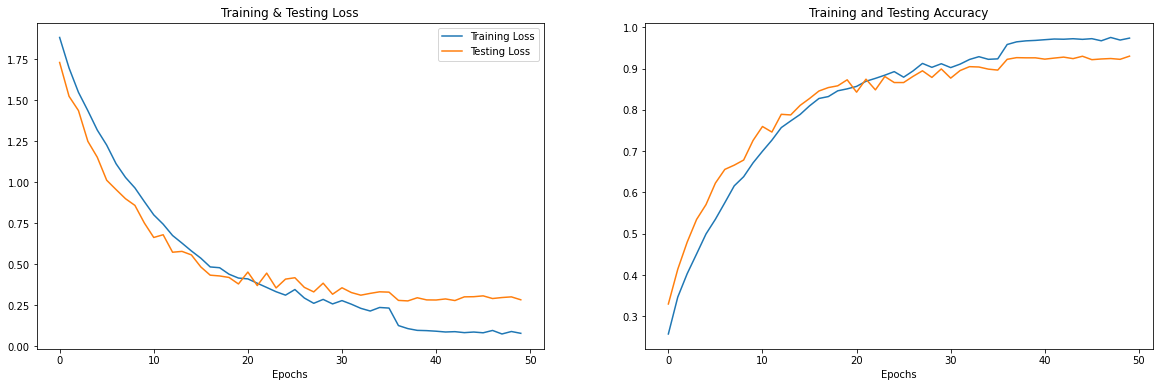

In [ ]:
print("Accuracy of the model is : " , model.evaluate(x_test,y_test)[1]*100, "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs, train_loss , label='Training Loss')
ax[0].plot(epochs, test_loss , label='Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc, label= 'Training Accuracy')
ax[1].plot(epochs , test_acc, label= 'Testing Accuracy')
ax[1].set_title('Training and Testing Accuracy')
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()
df.head(10)

,Predicted Labels,Actual Labels
0,calm,calm
1,fear,fear
2,happy,happy
3,happy,happy
4,fear,happy
5,surprise,surprise
6,sad,sad
7,angry,angry
8,calm,calm
9,calm,calm


Making a confusion Matrix

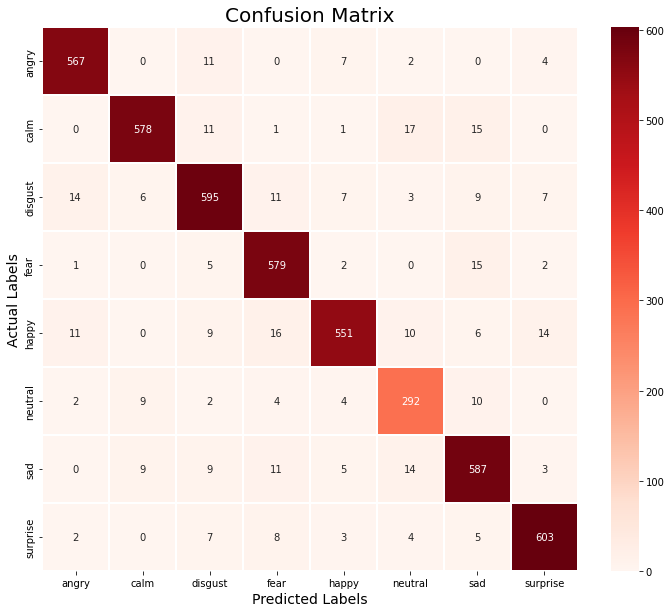

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm, index = [i for i in encoder.categories_], columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor ='white', cmap='Reds', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()